In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib.ticker import IndexLocator
import time, sys
import pickle
import torch
import torch.nn as nn

In [2]:
# Given parameters
nx = 60
ny = 60
tf = 5.0
dt = 1.0e-2
nt = int(tf/dt)
xmin = 0; xmax = 1
ymin = 0; ymax = 1
dims = (ny,nx)

# latent space dim.
f_list=np.array([3,4,5,6])
print('Latent Sapce Dim. {}'.format(f_list))

# parameters
p_inter=5
FOM_parameters = np.arange(75,125+1,1,dtype=int)
print("Prediction Parameters: {}".format(FOM_parameters))
print("training parameters={}".format(FOM_parameters[p_inter:-p_inter:p_inter]))

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

# file path
file_path_gappy_DEIM_result = "./wave_result/ex23_AE_swish_bndry_DEIM_gappy_result_seed_{}.p".format(seed)

# Gauss-Newton params
maxitr=4
tol=1e-8

# full, inner, bc index
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
x0_multi_index=(multi_index_j[:,0].flatten(),multi_index_i[:,0].flatten())
x1_multi_index=(multi_index_j[:,-1].flatten(),multi_index_i[:,-1].flatten())
y0_multi_index=(multi_index_j[0,:].flatten(),multi_index_i[0,:].flatten())
y1_multi_index=(multi_index_j[-1,:].flatten(),multi_index_i[-1,:].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
bc_raveled_indicies=np.unique(np.concatenate((x0_raveled_indicies,x1_raveled_indicies,
                                              y0_raveled_indicies,y1_raveled_indicies)))
inner_raveled_indicies=np.setdiff1d(full_raveled_indicies,bc_raveled_indicies)

Latent Sapce Dim. [3 4 5 6]
Prediction Parameters: [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
training parameters=[ 80  85  90  95 100 105 110 115 120]


In [3]:
def DEIM(phi_f, nfeval, unseen=np.array([])):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    
    l=0
    u=np.reshape(phi_f[:,l],(n,1))
    r=np.abs(u)
    if len(unseen) >0 :
        r[unseen]=ninf
    p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
    p=p_temp
    U=u
    
    ns=int(np.ceil((nfeval-1)/(m-1)))
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        for k in range(ns):
            if len(p)==nfeval:
                return p
            c=np.linalg.lstsq(U[p,:],u[p,:],rcond=None)[0]
            r=np.abs(u-U@c)
            r[p]=ninf
            if len(unseen) > 0:
                r[unseen]=ninf
            p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
            p=np.sort(np.append(p,p_temp))
        U=np.concatenate((U,u),axis=1)
         
    return p

Dim. of latent space is 3
# of measurments: 12
[   0    9   19   41   46   59  840 1680 1859 2100 3583 3599]
Dim. of latent space is 4
# of measurments: 12
[   0   14   24   42   53  420  899 1800 2940 3480 3580 3598]
Dim. of latent space is 5
# of measurments: 12
[   0    7   14   18   49   53 1440 2760 2999 3539 3551 3579]
Dim. of latent space is 6
# of measurments: 12
[   1    6   21   29 1080 2040 2460 2880 2999 3240 3552 3599]


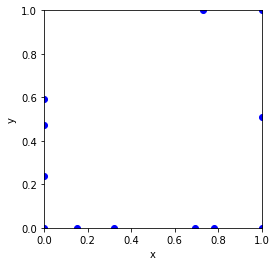

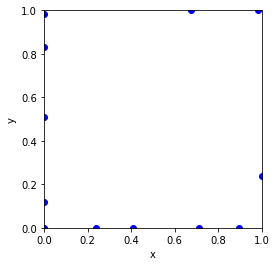

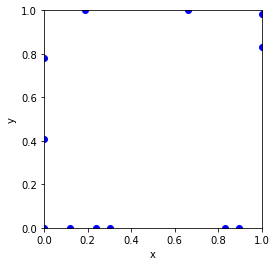

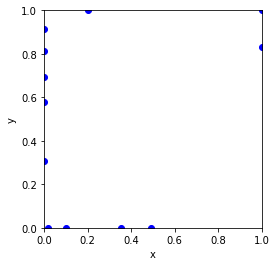

In [4]:
for ii in range(len(f_list)):
    f=f_list[ii]
    print("Dim. of latent space is {}".format(f))
    
    # file path
    file_name_AE="./wave_model/ex23_AE_{}_swish_seed_{}.p".format(f,seed)
    file_path_residual_SVD="./wave_model/ex23_AE_{}_swish_residual_SVD_seed_{}.p".format(f,seed)
    
    # DEIM
    with open(file=file_path_residual_SVD, mode='rb') as fff:
        SVD=pickle.load(fff)
    U=SVD['U']; S=SVD['S']
    num_msmt=12
#     plt.semilogy(S)
#     plt.show()
#     print("accuracy = {}".format(np.sum(S[:num_msmt]**2)/np.sum(S**2)*100))
    phi_r=U[:,:num_msmt]
    msmt_idx=DEIM(phi_r,num_msmt,inner_raveled_indicies)
    msmt_idx.sort()

    # precompute
    ZTphi_r=phi_r[msmt_idx]
    ZTphi_r_pinv=np.linalg.pinv(ZTphi_r)
    phi_rZTphi_r_pinv=phi_r.dot(ZTphi_r_pinv)

    num_msmt=len(msmt_idx)
    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig("./wave_result/ex23_AE_{}_swish_bndry_DEIM_{}_samples_seed_{}.png".format(f,num_msmt,seed))

# gappyAE

Dim. of latent space is 3
# of measurments: 12
[   0    9   19   41   46   59  840 1680 1859 2100 3583 3599]


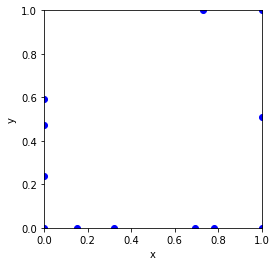

Param is 75
Time elapsed: 15.002772092819214 sec
average relative error of u: 1.3629687090227074%
maximum relative error of u: 2.126158656212608%

Param is 76
Time elapsed: 15.493497610092163 sec
average relative error of u: 1.2963003066748702%
maximum relative error of u: 2.0266932636730863%

Param is 77
Time elapsed: 15.862072229385376 sec
average relative error of u: 1.2353189664061537%
maximum relative error of u: 1.9329909267178689%

Param is 78
Time elapsed: 15.499730348587036 sec
average relative error of u: 1.1804307340507092%
maximum relative error of u: 1.8449666570391594%

Param is 79
Time elapsed: 14.707631587982178 sec
average relative error of u: 1.1320428608701671%
maximum relative error of u: 1.762646067169782%

Param is 80
Time elapsed: 14.345109224319458 sec
average relative error of u: 1.090546434804572%
maximum relative error of u: 1.6859761641365627%

Param is 81
Time elapsed: 14.386831521987915 sec
average relative error of u: 1.0562842807724955%
maximum relative 

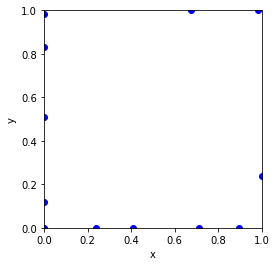

Param is 75
Time elapsed: 18.10085105895996 sec
average relative error of u: 0.8619672024330772%
maximum relative error of u: 1.7588315204715599%

Param is 76
Time elapsed: 17.232977390289307 sec
average relative error of u: 0.8295324549668198%
maximum relative error of u: 1.6991571498138833%

Param is 77
Time elapsed: 17.434105396270752 sec
average relative error of u: 0.799429966140507%
maximum relative error of u: 1.6414032051598137%

Param is 78
Time elapsed: 16.878108263015747 sec
average relative error of u: 0.7715039802232606%
maximum relative error of u: 1.5855279086639948%

Param is 79
Time elapsed: 17.18823552131653 sec
average relative error of u: 0.7455992082719505%
maximum relative error of u: 1.5313928806346597%

Param is 80
Time elapsed: 17.240469932556152 sec
average relative error of u: 0.7215637833671275%
maximum relative error of u: 1.4789225832000874%

Param is 81
Time elapsed: 16.03306794166565 sec
average relative error of u: 0.6992586327103935%
maximum relative e

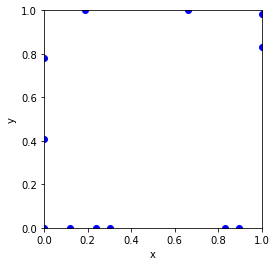

Param is 75
Time elapsed: 18.49196171760559 sec
average relative error of u: 0.8979615349199235%
maximum relative error of u: 2.4168038930575864%

Param is 76
Time elapsed: 17.438628673553467 sec
average relative error of u: 0.8615146252160003%
maximum relative error of u: 2.3286243767054007%

Param is 77
Time elapsed: 17.764249086380005 sec
average relative error of u: 0.8275571322407441%
maximum relative error of u: 2.2412043557416084%

Param is 78
Time elapsed: 17.577512502670288 sec
average relative error of u: 0.7958829578350346%
maximum relative error of u: 2.1893759175413474%

Param is 79
Time elapsed: 18.86097526550293 sec
average relative error of u: 0.7663038736976848%
maximum relative error of u: 2.1416275355438352%

Param is 80
Time elapsed: 19.82265043258667 sec
average relative error of u: 0.7386378411996073%
maximum relative error of u: 2.0910042592843006%

Param is 81
Time elapsed: 19.6575825214386 sec
average relative error of u: 0.7127361123060328%
maximum relative er

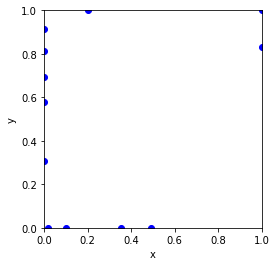

Param is 75
Time elapsed: 29.83522915840149 sec
average relative error of u: 0.5829401926718446%
maximum relative error of u: 1.3817339740144363%

Param is 76
Time elapsed: 26.452526092529297 sec
average relative error of u: 0.5580655491535134%
maximum relative error of u: 1.3264380828414613%

Param is 77
Time elapsed: 28.47105836868286 sec
average relative error of u: 0.5356655542498401%
maximum relative error of u: 1.2782538085137565%

Param is 78
Time elapsed: 26.55760431289673 sec
average relative error of u: 0.5154845123639776%
maximum relative error of u: 1.2322464123515322%

Param is 79
Time elapsed: 26.867331981658936 sec
average relative error of u: 0.4972950864553063%
maximum relative error of u: 1.1882681399545043%

Param is 80
Time elapsed: 26.194312810897827 sec
average relative error of u: 0.480854138540498%
maximum relative error of u: 1.146421206507911%

Param is 81
Time elapsed: 27.715571403503418 sec
average relative error of u: 0.465964111819234%
maximum relative err

In [5]:
solution=np.zeros((len(f_list),len(FOM_parameters),nt+1,nx*ny))
reduced=np.zeros((len(f_list),len(FOM_parameters),nt+1,f_list[-1]))
avg_rel_err=np.zeros((len(f_list),len(FOM_parameters)))
rel_err=np.zeros((len(f_list),len(FOM_parameters),nt+1))
elapsed_time=np.zeros((len(f_list),len(FOM_parameters)))

for ii in range(len(f_list)):
    f=f_list[ii]
    print("Dim. of latent space is {}".format(f))
    
    # file path
    file_name_AE="./wave_model/ex23_AE_{}_swish_seed_{}.p".format(f,seed)
    file_path_residual_SVD="./wave_model/ex23_AE_{}_swish_residual_SVD_seed_{}.p".format(f,seed)
    
    # DEIM
    with open(file=file_path_residual_SVD, mode='rb') as fff:
        SVD=pickle.load(fff)
    U=SVD['U']; S=SVD['S']
    num_msmt=12
#     plt.semilogy(S)
#     plt.show()
#     print("accuracy = {}".format(np.sum(S[:num_msmt]**2)/np.sum(S**2)*100))
    phi_r=U[:,:num_msmt]
    msmt_idx=DEIM(phi_r,num_msmt,inner_raveled_indicies)
    msmt_idx.sort()

    # precompute
    ZTphi_r=phi_r[msmt_idx]
    ZTphi_r_pinv=np.linalg.pinv(ZTphi_r)
    phi_rZTphi_r_pinv=phi_r.dot(ZTphi_r_pinv)

    num_msmt=len(msmt_idx)
    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    with open(file=file_name_AE, mode='rb') as ff:    
        AE = pickle.load(ff)

    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    latent_dim=de_wu1.shape[1]
    
    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = z1 * sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT
    
    m,M2=de_wu2.shape

    class Decoder_U_FC(nn.Module):

        def __init__(self,):
            super(Decoder_U_FC, self).__init__()
            self.fc1 = nn.Linear(latent_dim,M2)
            self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
            self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
    #         self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = Decoder_U_FC()

    x_in=torch.ones(latent_dim)
    y_out=model(x_in)

    p_hr=msmt_idx

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    wu1_mask=model.fc1.weight.grad
    wu2_mask=model.fc2.weight.grad

    bu1_mask=model.fc1.bias.grad

    # subnet sparse weight
    idx1=wu1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_wu1[i1,j1]
    wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

    idx2=wu2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_wu2[i2,j2]
    wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(wu1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(wu2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
    wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
    wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

    wu1_sb_comp_denseT=wu1_sb_comp_dense.T
    wu2_sb_comp_denseT=wu2_sb_comp_dense.T

    # subnet compressed bias
    bu1_sb_comp_dense=de_bu1[i1_unique]
    bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

    # Using sparse matrix
    wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
    wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

    def decoder_u_sb_np_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = z1 * sigmoid_np(z1)
        y = wu2_sb_comp_dense.dot(a1)  
        return y

    def decoder_u_sb_np_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = wu2_sb_comp_dense.dot(a1) 

        dout = wu1_sb_comp_denseT
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(wu2_sb_comp_denseT)
        return y,dydxT

    def decoder_u_sb_sp_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
        return y

    def decoder_u_sb_sp_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

        dout = wu1_sb_comp_denseT
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
        return y,dydxT

    for jj in range(len(FOM_parameters)):
        FOM_parameter=FOM_parameters[jj]
        print("Param is {}".format(FOM_parameter))
        
        # Load FOM solution
        ex = np.load('./wave_data/ex23_interp_{}.npz'.format(FOM_parameter), allow_pickle = True)
        ex = ex.f.arr_0
        u_full = ex.reshape(nt+1,-1).astype('float32')

        # take measurments
        um = u_full[:,msmt_idx]

        # Initial condition
        u0=u_full[0]
        u_hat0=encoder_u_np_forward(u0.astype('float32')-u_ref)

        # gappyAE
        t_start_gappyAE=time.time()

        # solution
        u_reduced=np.zeros((nt+1,latent_dim))
        u_gappyAE=np.zeros((nt+1,ny*nx))

        # IC
        u_reduced[0]=np.copy(u_hat0)
        u_gappyAE[0]=np.copy(u0)

        for k in range(nt):
#             print("")
#             print(k,"th time step:")

            u_hatw=np.copy(u_reduced[k])

            umw,Jg_umT=decoder_u_sb_sp_forward_backwardT(u_hatw)

            umw += u_ref[msmt_idx]

            J_r=-Jg_umT.T
            J_pinv=np.linalg.pinv(ZTphi_r_pinv.dot(J_r)).dot(ZTphi_r_pinv)

            r_um_hat = um[k+1]-umw

            res = np.linalg.norm(J_pinv.dot(r_um_hat))
#             res = np.linalg.norm(r_um_hat)
            res_hist=[res]
            for itr in range(maxitr):
                du_hatw = J_pinv.dot(r_um_hat)

                u_hatw -= du_hatw

                umw,Jg_umT=decoder_u_sb_sp_forward_backwardT(u_hatw)

                umw += u_ref[msmt_idx]

                J_r=-Jg_umT.T
                J_pinv=np.linalg.pinv(ZTphi_r_pinv.dot(J_r)).dot(ZTphi_r_pinv)

                r_um_hat = um[k+1]-umw

                res = np.linalg.norm(J_pinv.dot(r_um_hat))
#                 res = np.linalg.norm(r_um_hat)
                res_hist.append(res)
#                 print(itr,"th Newton iteration", "res:", "{:.8e}".format(res))

                if res<tol:
                    break

            u_reduced[k+1]=u_hatw.copy()
            u_gappyAE[k+1]=u_ref+decoder_u_sp_forward(u_reduced[k+1])

        # elapsed time    
        t_elapsed_gappyAE=time.time()-t_start_gappyAE
        print('Time elapsed: {} sec'.format(t_elapsed_gappyAE))

        # error
        u_rel_err_gappyAE=np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)\
                         /np.linalg.norm(u_full,ord=2,axis=1)*100
        u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)**2))\
                     /np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
        print("average relative error of u: {}%".format(u_avg_rel_err))
        print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyAE)))
        print()

        # save result
        solution[ii,jj]=u_gappyAE
        reduced[ii,jj,:,:f]=u_reduced
        avg_rel_err[ii,jj]=u_avg_rel_err
        rel_err[ii,jj]=u_rel_err_gappyAE
        elapsed_time[ii,jj]=t_elapsed_gappyAE
    
results={'solution':solution,'reduced':reduced,'avg_rel_err':avg_rel_err,'rel_err':rel_err,'elapsed_time':elapsed_time}
with open(file=file_path_gappy_DEIM_result, mode='wb') as ff:
    pickle.dump(results, ff)

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

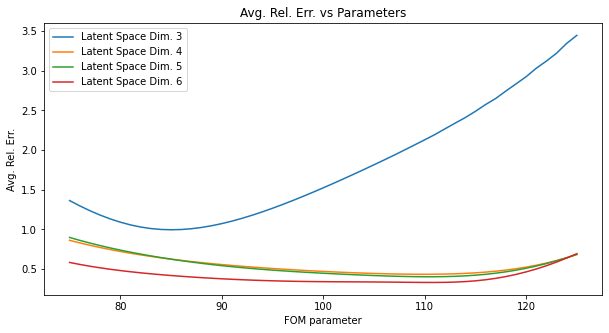

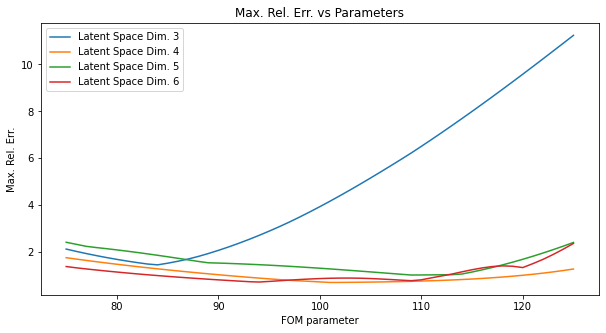

In [6]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

idx=[0,1,2,3]

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:  
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['avg_rel_err'][i][p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_AE_bndry_DEIM_avg_rel_err_seed_{}.png".format(seed))

# figure rel.err vs data points
plt.figure(figsize=(10,5)) 
for i in idx:  
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['rel_err'][i].max(axis=1)[p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_AE_bndry_DEIM_max_rel_err_seed_{}.png".format(seed))

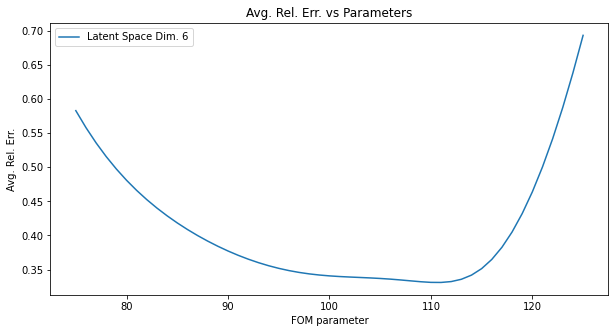

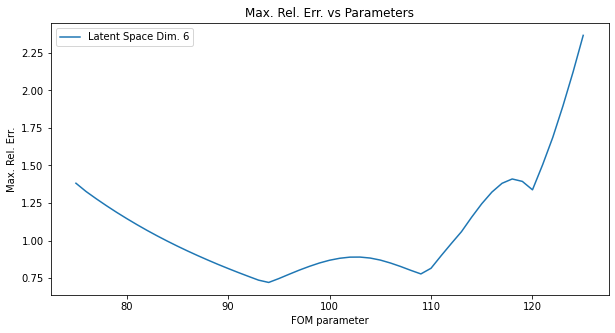

In [7]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

# idx=[0,1,2,3]
idx = [3]

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:  
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['avg_rel_err'][i][p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Avg. Rel. Err. vs Parameters')
plt.show()

# figure rel.err vs data points
plt.figure(figsize=(10,5)) 
for i in idx:  
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['rel_err'][i].max(axis=1)[p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Max. Rel. Err. vs Parameters')
plt.show()

In [8]:
print(f_list)
print(FOM_parameters)

[3 4 5 6]
[ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]


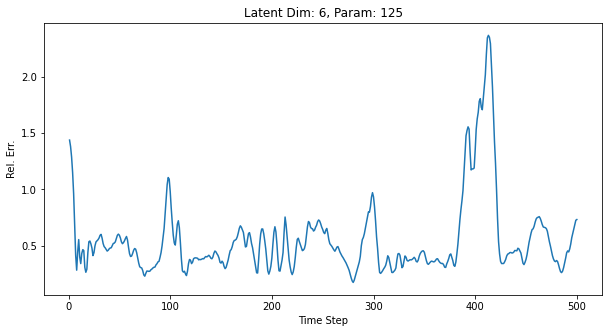

average relative error of u: 0.6933401633019816%

maximum relative error of u: 2.367088644667649%


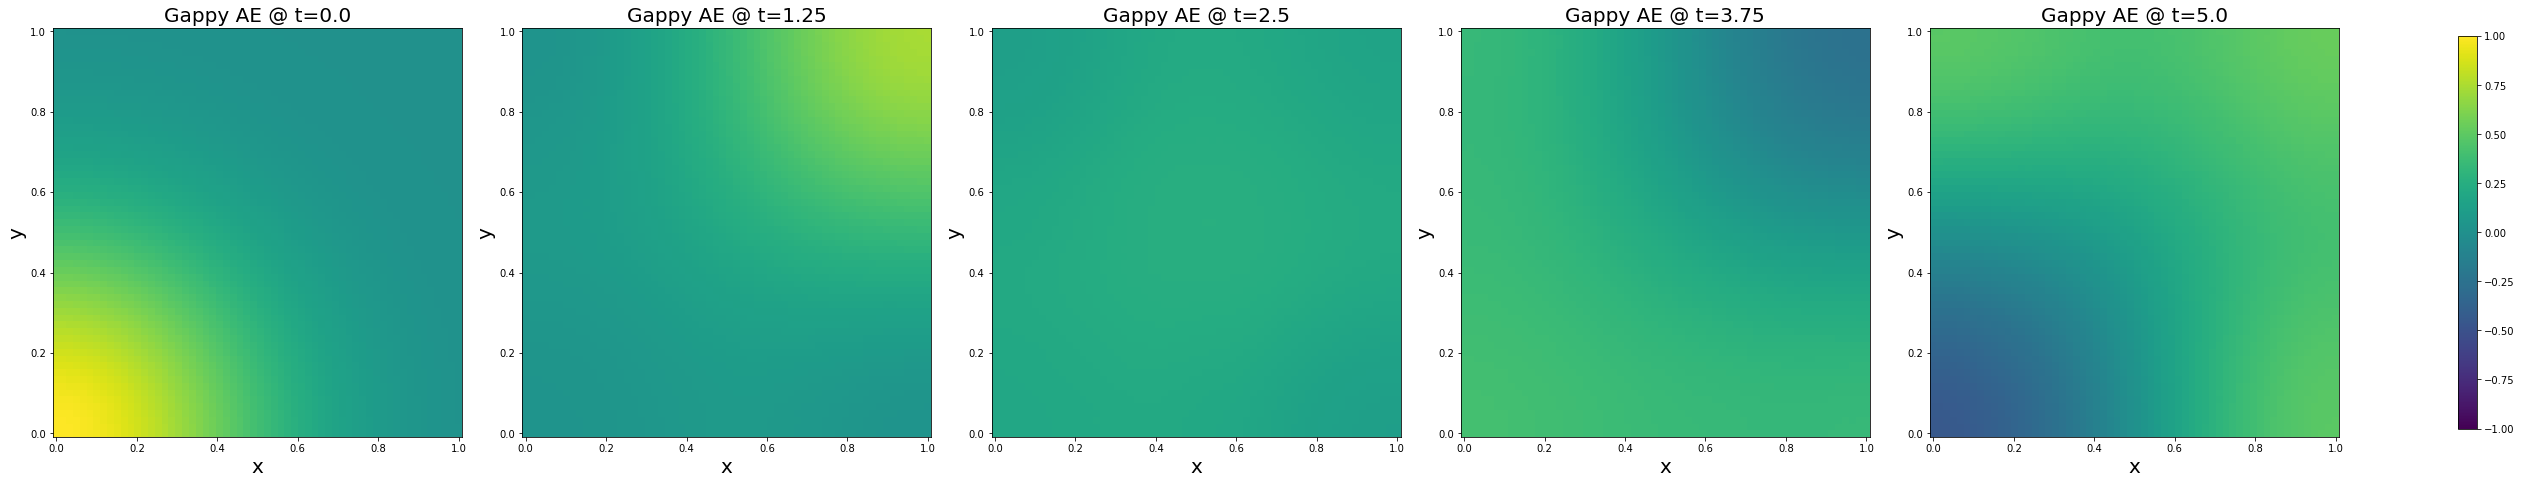

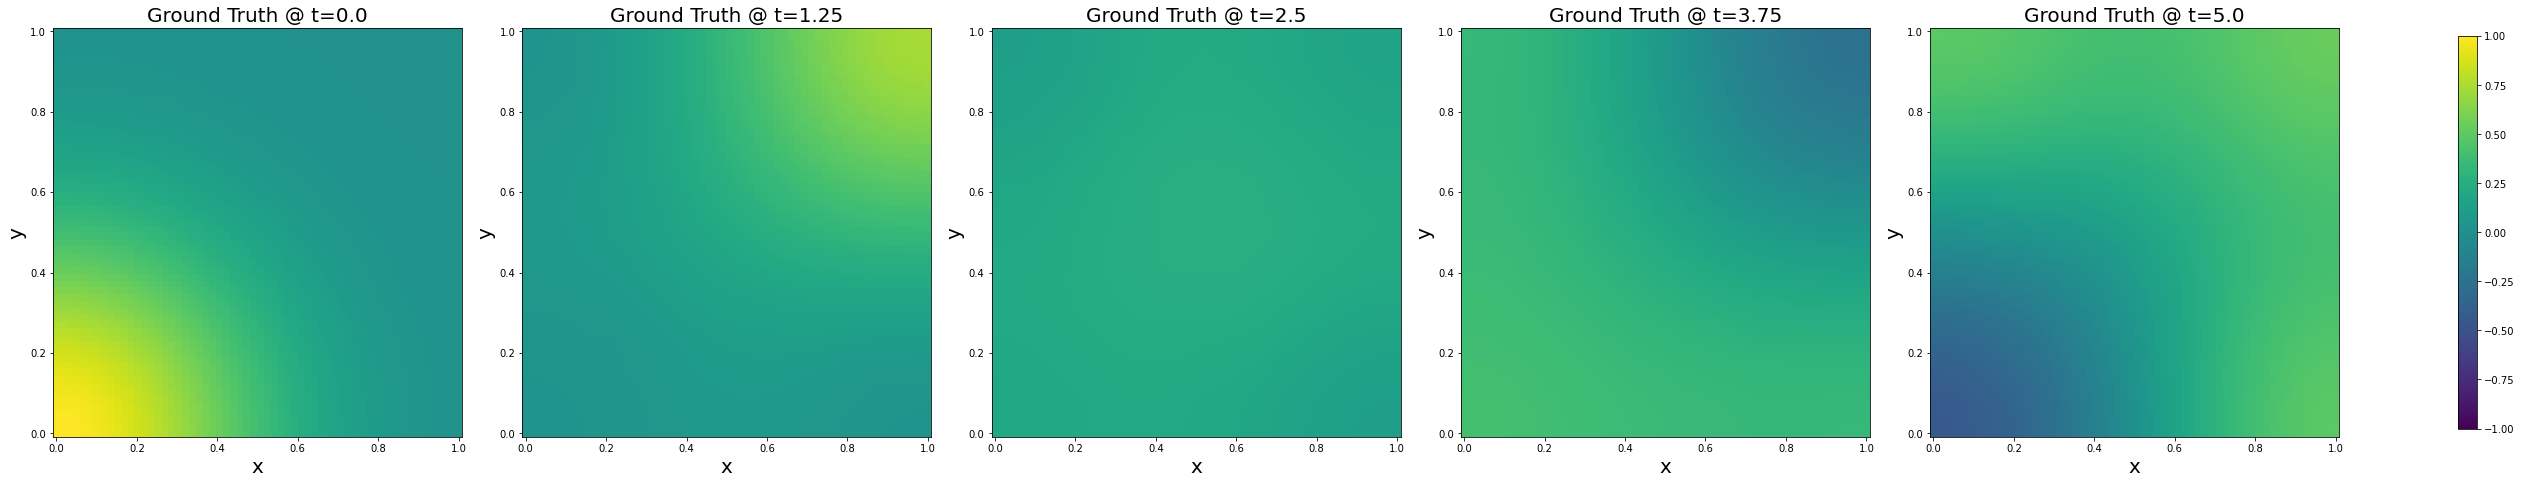

In [9]:
# figure rel.err vs at given param and POD basis
i=3; j=-1        
f=f_list[i]
param=FOM_parameters[j]

u_gappyAE=results['solution'][i,j]

ex = np.load('./wave_data/ex23_interp_{}.npz'.format(param), allow_pickle = True)
ex = ex.f.arr_0
u_full = ex.reshape(nt+1,-1)

plt.figure(figsize=(10,5))
plt.plot(np.arange(1,nt+1),results['rel_err'][i,j,1:].flatten())
plt.xlabel('Time Step')
plt.ylabel('Rel. Err.')
plt.title("Latent Dim: {}, Param: {}".format(f,param))
plt.show()

# error
u_rel_err_gappyAE=np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)\
                 /np.linalg.norm(u_full,ord=2,axis=1)*100
u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)**2))\
             /np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
print("average relative error of u: {}%".format(u_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyAE)))
    
# plot original data
vmin=-1; vmax=1
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Gappy AE @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./wave_result/ex23_AE_{}_param_{}_bndry_DEIM_SOL_seed_{}.png".format(f,param,seed))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Ground Truth @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./wave_result/ex23_param_{}_ground_truth.png".format(param))

f=6
param=125


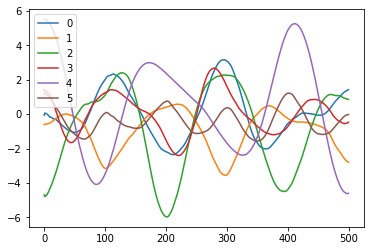

In [10]:
i=3; j=-1
f=f_list[i]; param=FOM_parameters[j]
print("f={}".format(f))
print("param={}".format(param))
plt.plot(results['reduced'][i,j][:,:f])
plt.legend(np.arange(f))
plt.show()